In [1]:
import numpy as np
import pandas as pd

import os
import pathlib

import datetime
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pvlib


In [13]:
data_pt = os.path.join('data', "222628_32.73_-117.18_2012.csv")

axis_azimuth = 180
axis_tilt = 32
module_power = 500

number_of_modules = 50/(module_power*0.001*0.001)

lat, lon = 32.73, -117.18
offset = 7

In [16]:
nsrdb = pd.read_csv(data_pt, skiprows=2, usecols=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI',
       'DNI', 'Surface Albedo', 'Wind Speed', 'Pressure'])
local_index = pd.DatetimeIndex(nsrdb['Year'].astype(str) + '-' + nsrdb['Month'].astype(str) +
                             '-' + nsrdb['Day'].astype(str) + ' ' + nsrdb['Hour'].astype(str) +
                               ':' + nsrdb['Minute'].astype(str))
nsrdb.set_index(local_index, inplace=True)

In [17]:
start_date = str(nsrdb.index[0])
end_date = str(nsrdb.index[-1])

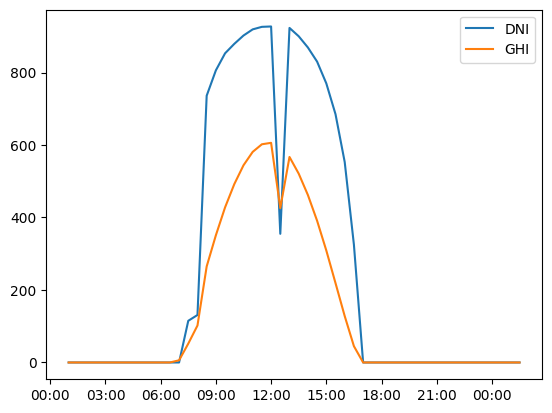

In [18]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = nsrdb.index[50:100]
ax.plot(idx, nsrdb.loc[idx, "DNI"], label='DNI')
ax.plot(idx, nsrdb.loc[idx, "GHI"], label='GHI')
ax.legend()

Interpolating NSRDB data

In [19]:
times_interp = pd.date_range(start_date, end_date, freq='5min')

nsrdb_interpolated = pd.DataFrame(index=times_interp)
nsrdb_interpolated['dni_extra'] = pvlib.irradiance.get_extra_radiation(nsrdb_interpolated.index)
times_float = times_interp.to_numpy().astype(float)
for i in nsrdb.columns:
    cs = CubicSpline(nsrdb.index.to_numpy().astype(float), nsrdb[i].values)
    nsrdb_interpolated[i] = cs(times_float)
    nsrdb_interpolated[i] = np.maximum(nsrdb_interpolated[i], 0)


Plot interpolated vs. original

Text(0, 0.5, 'GHI [w/m2]')

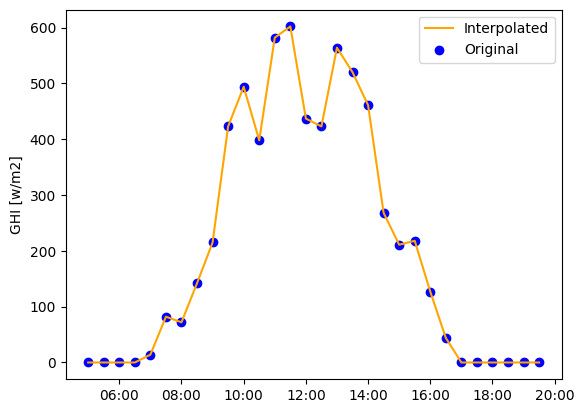

In [20]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = nsrdb.index[10:40]
start = idx[0]
end = idx[-1]

interpolated_idx = nsrdb_interpolated[start:end].index
ax.plot(idx, nsrdb_interpolated.loc[idx, "GHI"], label='Interpolated', c='orange')

ax.scatter(idx, nsrdb.loc[idx, "GHI"], label='Original', c='b')
ax.legend()
ax.set_ylabel('GHI [w/m2]')

Get solar position

In [21]:

loc = pvlib.location.Location(lat,lon, altitude=0)
fake_index = pd.date_range(datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=-offset),
                           datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=offset), freq='5min')
solar_position = loc.get_solarposition(times=fake_index)
solar_position.set_index(solar_position.index.shift(periods=-offset, freq = '1h'), inplace = True)
solar_position = solar_position.loc[times_interp]
data = pd.concat([nsrdb_interpolated, solar_position], axis=1)

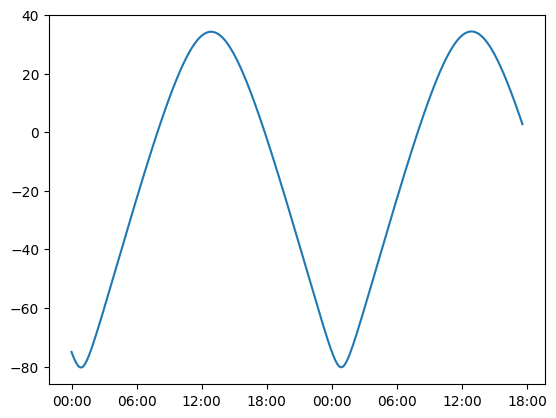

In [22]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index[:500]
ax.plot(idx, data.loc[idx, "elevation"])

Transpose irradiance measurements to plane-of-array

In [23]:
poa = pvlib.irradiance.get_total_irradiance(axis_tilt, axis_azimuth,
                                            data['zenith'], data["azimuth"],
                                            data['DNI'], data['GHI'], data['DHI'],
                                            data["dni_extra"], model="haydavies")

aoi = pvlib.irradiance.aoi(axis_tilt, axis_azimuth, data['zenith'], data["azimuth"])
am_rel = pvlib.atmosphere.get_relative_airmass(data['zenith'])
am_abs = pvlib.atmosphere.get_absolute_airmass(am_rel, data['Pressure'])


Get panel specs

In [24]:
mod_db_cec = pvlib.pvsystem.retrieve_sam('CECMod')
mod_db_sandia = pvlib.pvsystem.retrieve_sam('SandiaMod')

In [25]:

module_cec = mod_db_cec['Canadian_Solar_Inc__CS6K_300M']
module_sandia = mod_db_sandia['Canadian_Solar_CS6X_300M__2013_']


In [26]:

stc_mod_p = module_cec['STC']
Gpmp = module_cec['gamma_r']
temp_ref=25.0

temp_model = 'sapm'
temp_model_material = 'open_rack_glass_polymer'
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS[temp_model][temp_model_material]

In [27]:
t_cell = pvlib.temperature.sapm_cell(poa['poa_global'],
                                    data['Temperature'].values,
                                    data['Wind Speed'].values,
                                    **temperature_model_parameters)

In [28]:

# Effective Irradiance
eff_irr = pvlib.pvsystem.sapm_effective_irradiance(poa['poa_direct'],
                                                    poa['poa_diffuse'],
                                                    am_abs, aoi, module_sandia)

In [29]:

# Power is linear with irradiance in PVWatts
pvw = pvlib.pvsystem.pvwatts_dc(eff_irr, t_cell, stc_mod_p, Gpmp, temp_ref) 
    